# LSTM On Earthquake Time Series Data

In [ ]:
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from enum import Enum
import time

In [ ]:
torch_data_type = torch.float32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class FileData:
    def __init__(
        self,
        name,
        acc_index,
        vel_index,
        dsp_index,
        lst_index,
        dt_acc,
        dt_vel,
        dt_dsp,
        unit_acc,
        unit_vel,
        unit_dsp,
        acc_values,
        vel_values,
        dsp_values,
        dt_sampling,
        acc_values_sampled,
        vel_values_sampled,
        dsp_values_sampled,
    ):
        self.name = name
        self.acc_index = acc_index
        self.vel_index = vel_index
        self.dsp_index = dsp_index
        self.lst_index = lst_index
        self.dt_acc = dt_acc
        self.dt_vel = dt_vel
        self.dt_dsp = dt_dsp
        self.unit_acc = unit_acc
        self.unit_vel = unit_vel
        self.unit_dsp = unit_dsp
        self.acc_values = acc_values
        self.vel_values = vel_values
        self.dsp_values = dsp_values
        self.dt_sampling = dt_sampling
        self.acc_values_sampled = acc_values_sampled
        self.vel_values_sampled = vel_values_sampled
        self.dsp_values_sampled = dsp_values_sampled
        self.ID = 0
        self.u_r = None
        self.ud_r = None
        self.udd_r = None
        self.t = None  # time vector

    def __str__(self) -> str:
        return f"{self.name, self.acc_index, self.vel_index, self.dsp_index, self.lst_index, self.dt_acc, self.dt_dsp, self.unit_acc, self.unit_vel, self.unit_dsp, self.acc_values, self.vel_values, self.dsp_values, self.dt_sampling, self.acc_values_sampled, self.vel_values_sampled, self.dsp_values_sampled, self.ID, self.u_r, self.ud_r, self.udd_r, self.t}"

    def __repr__(self) -> str:
        return self.__str__()

In [ ]:
class NormalizationOption(Enum):
    NoScaling = 0
    ScaleShiftStandard = 1
    ScaleShiftAll = 2
    ScaleAll = 3
    ScaleFeatureBased = 4

class TensorsType(Enum):
    Tensorflow = 0
    Torch = 1

class Dataset:
    def __init__(self, filename: str, normalizationOption: NormalizationOption):
      self.data = np.asarray(pd.read_pickle(filename), dtype=object)
      self.normalizationOption = normalizationOption

      self.max_timesteps = max(len(file_data.acc_values_sampled) for file_data in self.data)
      self.min_timesteps = min(len(file_data.acc_values_sampled) for file_data in self.data)

      self.max_abs_acc_input  = max(np.absolute(file_data.acc_values_sampled).max() for file_data in self.data)
      self.max_abs_acc_output = max(np.absolute(file_data.udd_r).max() for file_data in self.data)
      self.max_abs_vel_output = max(np.absolute(file_data.ud_r).max() for file_data in self.data)
      self.max_abs_dsp_output = max(np.absolute(file_data.u_r).max() for file_data in self.data)

      self.max_acc_input  = max(file_data.acc_values_sampled.max() for file_data in self.data)
      self.max_acc_output = max(file_data.udd_r.max() for file_data in self.data)
      self.max_vel_output = max(file_data.ud_r.max() for file_data in self.data)
      self.max_dsp_output = max(file_data.u_r.max() for file_data in self.data)

      self.min_acc_input  = min(file_data.acc_values_sampled.min() for file_data in self.data)
      self.min_acc_output = min(file_data.udd_r.min() for file_data in self.data)
      self.min_vel_output = min(file_data.ud_r.min() for file_data in self.data)
      self.min_dsp_output = min(file_data.u_r.min() for file_data in self.data)

      self.max_abs_all = max([self.max_abs_acc_input, self.max_abs_acc_output, self.max_abs_vel_output, self.max_abs_dsp_output])
      self.max_all     = max([self.max_acc_input, self.max_acc_output, self.max_vel_output, self.max_dsp_output])
      self.min_all     = min([self.min_acc_input, self.min_acc_output, self.min_vel_output, self.min_dsp_output])

      self.start_index=0
      self.end_index=self.min_timesteps
      self.sequence_length=self.end_index - self.start_index
      self.n_earthquakes=len(self.data)

    def print_stats(self):
      print(f'dataset.max_timesteps      {self.max_timesteps     }')
      print(f'dataset.min_timesteps      {self.min_timesteps     }')
      print(f'dataset.max_abs_acc_input  {self.max_abs_acc_input }')
      print(f'dataset.max_abs_acc_output {self.max_abs_acc_output}')
      print(f'dataset.max_abs_vel_output {self.max_abs_vel_output}')
      print(f'dataset.max_abs_dsp_output {self.max_abs_dsp_output}')
      print(f'dataset.max_acc_input      {self.max_acc_input     }')
      print(f'dataset.max_acc_output     {self.max_acc_output    }')
      print(f'dataset.max_vel_output     {self.max_vel_output    }')
      print(f'dataset.max_dsp_output     {self.max_dsp_output    }')
      print(f'dataset.min_acc_input      {self.min_acc_input     }')
      print(f'dataset.min_acc_output     {self.min_acc_output    }')
      print(f'dataset.min_vel_output     {self.min_vel_output    }')
      print(f'dataset.min_dsp_output     {self.min_dsp_output    }')
      print(f'dataset.max_abs_all        {self.max_abs_all       }')
      print(f'dataset.max_all            {self.max_all           }')
      print(f'dataset.min_all            {self.min_all           }')

    def normalize_sequence(self,x,featureIndex=0):
      if self.normalizationOption == NormalizationOption.NoScaling:
        return x
      if self.normalizationOption == NormalizationOption.ScaleShiftStandard:
        min_value = np.min(x)
        max_value = np.max(x)
        return (x - min_value) / (max_value - min_value)
      if self.normalizationOption == NormalizationOption.ScaleShiftAll:
        return (x - self.min_all) / (self.max_all - self.min_all)
      if self.normalizationOption == NormalizationOption.ScaleAll:
        return (x) / (self.max_abs_all)
      if self.normalizationOption == NormalizationOption.ScaleFeatureBased:
        if featureIndex == 0:
          return (x) / max([self.max_abs_acc_input,self.max_abs_acc_output])
        if featureIndex == 2:
          return (x) / self.max_abs_vel_output
        if featureIndex == 1:
          return (x) / self.max_abs_dsp_output

    def rebase_sequence(self,x,featureIndex=0):
      if self.normalizationOption == NormalizationOption.ScaleShiftAll:
        return (x * (self.max_all - self.min_all) +  self.min_all)
      if self.normalizationOption == NormalizationOption.ScaleAll:
        return (x) * (self.max_abs_all)
      if self.normalizationOption == NormalizationOption.ScaleFeatureBased:
        if featureIndex == 0:
          return (x) * max([self.max_abs_acc_input,self.max_abs_acc_output])
        if featureIndex == 2:
          return (x) * self.max_abs_vel_output
        if featureIndex == 1:
          return (x) * self.max_abs_dsp_output

      return x


    def get_ground_acc(self):
      ground_acc = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        acc_data = data.acc_values_sampled[self.start_index:self.end_index]
        ground_acc[i] = self.normalize_sequence(acc_data,0)

      return ground_acc

    def get_response_acc(self):
      response_acc = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        acc_data = data.udd_r[self.start_index:self.end_index]
        response_acc[i] = self.normalize_sequence(acc_data,0)

      return response_acc

    def get_ground_vel(self):
      ground_vel = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        vel_data = data.vel_values_sampled[self.start_index:self.end_index]
        ground_vel[i] = self.normalize_sequence(vel_data,2)

      return ground_vel

    def get_response_vel(self):
      response_vel = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        vel_data = data.ud_r[self.start_index:self.end_index]
        response_vel[i] = self.normalize_sequence(vel_data,2)

      return response_vel

    def get_ground_dsp(self):
      ground_dsp = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        dsp_data = data.dsp_values_sampled[self.start_index:self.end_index]
        ground_dsp[i] = self.normalize_sequence(dsp_data,1)

      return ground_dsp

    def get_response_dsp(self):
      response_dsp = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        dsp_data = data.u_r[self.start_index:self.end_index]
        response_dsp[i] = self.normalize_sequence(dsp_data,1)
      return response_dsp

    def split_data(self,tensorType,n_features,init_zeros):
      x = self.get_ground_acc()
      y1 = self.get_response_acc()
      y2 = self.get_response_dsp()


      if init_zeros > 0 :
        init_zeros_tensor = np.zeros((x.shape[0],init_zeros))
        x=np.concatenate((init_zeros_tensor , x), axis=1)
        y1=np.concatenate((init_zeros_tensor , y1), axis=1)
        y2=np.concatenate((init_zeros_tensor , y2), axis=1)

      x = np.expand_dims(x, axis=2)
      if n_features == 1:
        y = np.expand_dims(y1, axis=2)
      elif n_features == 2:
        y = np.dstack((y1,y2))

      x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 13)


      if tensorType == TensorsType.Tensorflow:
        x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
        x_val_tensor = tf.convert_to_tensor(x_val, dtype=tf.float32)
        y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_val_tensor =tf.convert_to_tensor(y_val, dtype=tf.float32)
      elif tensorType == TensorsType.Torch:
        x_train_tensor = torch.from_numpy(x_train).to(torch_data_type)
        x_val_tensor = torch.from_numpy(x_val).to(torch_data_type)
        y_train_tensor = torch.from_numpy(y_train).to(torch_data_type)
        y_val_tensor = torch.from_numpy(y_val).to(torch_data_type)

      return x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset

class TrainingDataset(TorchDataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [ ]:
def plot_data(sequence1, sequence2, title, xlabel, ylabel, label1="Real", label2="Predicted"):
  x = np.arange(start=0, stop=len(sequence1), step=1) * 0.005 # time step is 0.005

  plt.plot(x, sequence1, label=label1)
  plt.plot(x, sequence2, "--", label=label2)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

In [ ]:
dataset = Dataset("/content/drive/MyDrive/DL_Training_Data/all_eq_processed_data_ID_m_SDOF_linear_v003.pickle",NormalizationOption.ScaleFeatureBased)
dataset.print_stats()

dataset.max_timesteps      26799
dataset.min_timesteps      11201
dataset.max_abs_acc_input  0.9249152239983484
dataset.max_abs_acc_output 3.2218021366507346
dataset.max_abs_vel_output 0.2046758270233766
dataset.max_abs_dsp_output 0.014122405412496458
dataset.max_acc_input      0.9249152239983484
dataset.max_acc_output     3.2218021366507346
dataset.max_vel_output     0.2046758270233766
dataset.max_dsp_output     0.013713759752471104
dataset.min_acc_input      -0.772271468355947
dataset.min_acc_output     -3.0468937400870733
dataset.min_vel_output     -0.2005713543588934
dataset.min_dsp_output     -0.014122405412496458
dataset.max_abs_all        3.2218021366507346
dataset.max_all            3.2218021366507346
dataset.min_all            -3.0468937400870733


Features of interest:

1 => Acceleration only

2 => Acceleration and Displacement

Zeros are inserted at the begining of each sequence to stabilize the model response and avoid overshooting at the begining of response

In [ ]:
n_features_of_interest = 2
n_zeros_at_the_beginning = 2
batch_size = 8
x_train, x_test, y_train, y_test = dataset.split_data(TensorsType.Torch,n_features_of_interest,n_zeros_at_the_beginning)
train_dataloader=torch.utils.data.DataLoader(TrainingDataset(x_train,y_train), batch_size=batch_size, shuffle=False,  num_workers=1)
test_dataloader =torch.utils.data.DataLoader(TrainingDataset(x_test,y_test)  , batch_size=batch_size, shuffle=False,  num_workers=1)

In [ ]:
train_input, train_output_target = next(iter(train_dataloader))
print(f'First input batch shape  {train_input.shape}')
print(f'First output batch shape {train_output_target.shape}')
print(f'First Record Max Scaled Acceleration  = {train_output_target[0,:,0].numpy().max():6.4f}')
print(f'First Record Max Scaled Displacement  = {train_output_target[0,:,1].numpy().max():6.4f}')
print(f'First Record Max Unscaled Acceleration  = {dataset.rebase_sequence(train_output_target[0,:,0].numpy(),0).max():6.4f}')
print(f'First Record Max Unscaled Displacement  = {dataset.rebase_sequence(train_output_target[0,:,1].numpy(),1).max():6.4f}')

First input batch shape  torch.Size([8, 11203, 1])
First output batch shape torch.Size([8, 11203, 2])
First Record Max Scaled Acceleration  = 0.1578
First Record Max Scaled Displacement  = 0.1101
First Record Max Unscaled Acceleration  = 0.5085
First Record Max Unscaled Displacement  = 0.0016


# Defining Model

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
best_model_path="/content/drive/MyDrive/DL_Training_Data/model_LSTM_Best_028.pt"
last_model_path="/content/drive/MyDrive/DL_Training_Data/model_LSTM_Last_028.pt"

In [ ]:
class StructuralResponseLSTM(nn.Module):
    def __init__(self, input_size, hidden_lstm_size, out_features, num_layers):
        super(StructuralResponseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_lstm_size, num_layers=num_layers, bias=True, batch_first=True, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=torch_data_type)
        self.linear1 = torch.nn.Linear(hidden_lstm_size, out_features, bias=True, device=None, dtype=torch_data_type)
        # batch_first=True because input data has patch dimension first

    def forward(self, x):
        lstm_output, _ = self.lstm(x)              # (batch_size , sequence length , hidden_lstm_size)
        linear1_output = self.linear1(lstm_output) # (batch_size , sequence length , out_features)
        return linear1_output


floors_number = 1
response_per_floor = n_features_of_interest # acceleration and displacement
input_size = 1 # acceleration
hidden_lstm_size = 128 # Hidden layer size
out_features = floors_number * response_per_floor
num_layers = 1  # Number of layers in LSTM
learning_rate = 0.00005 # 0.001 default


# Initialize the model, loss function, and optimizer
model = StructuralResponseLSTM(input_size, hidden_lstm_size, out_features, num_layers).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_values = []

In [ ]:
def train_for_num_epochs(num_epochs):
  st = time.time() # total training start time
  for epoch in range(num_epochs):
      st_e = time.time() # epoch training start time
      epoch_loss = 0
      for inputs, target_outputs in train_dataloader:
          # Forward pass
          outputs = model(inputs.to(DEVICE))
          loss = criterion(outputs, target_outputs.to(DEVICE))
          epoch_loss += loss.item()

          # Backward and optimize
          model.zero_grad()
          loss.backward()
          optimizer.step()

      loss_value = epoch_loss/len(train_dataloader)
      loss_values.append(loss_value)
      et_e = time.time() # epoch training end time
      if loss_value <= min(loss_values):
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch [{epoch+1:4.0f}/{num_epochs:4.0f}], Loss: {loss_value:.8f} , execution time: {(et_e - st_e)/60:.3f} minutes || New Best ....')
      elif (epoch+1)%50 == 0:
        print(f'Epoch [{epoch+1:4.0f}/{num_epochs:4.0f}], Loss: {loss_value:.8f} , execution time: {(et_e - st_e)/60:.3f} minutes')
  et = time.time() # total training end time
  print(f'Total training execution time: {(et - st)/60:.2f} minutes')
  torch.save(model.state_dict(), last_model_path)

In [ ]:
train_for_num_epochs(2000)

Epoch [   1/2000], Loss: 0.00546576 , execution time: 0.021 minutes || New Best ....
Epoch [   2/2000], Loss: 0.00510852 , execution time: 0.006 minutes || New Best ....
Epoch [   3/2000], Loss: 0.00478643 , execution time: 0.006 minutes || New Best ....
Epoch [   4/2000], Loss: 0.00449799 , execution time: 0.006 minutes || New Best ....
Epoch [   5/2000], Loss: 0.00424067 , execution time: 0.006 minutes || New Best ....
Epoch [   6/2000], Loss: 0.00401229 , execution time: 0.006 minutes || New Best ....
Epoch [   7/2000], Loss: 0.00381096 , execution time: 0.006 minutes || New Best ....
Epoch [   8/2000], Loss: 0.00363497 , execution time: 0.006 minutes || New Best ....
Epoch [   9/2000], Loss: 0.00348262 , execution time: 0.006 minutes || New Best ....
Epoch [  10/2000], Loss: 0.00335222 , execution time: 0.006 minutes || New Best ....
Epoch [  11/2000], Loss: 0.00324201 , execution time: 0.006 minutes || New Best ....
Epoch [  12/2000], Loss: 0.00315019 , execution time: 0.006 minut

Min Loss 0.00005539


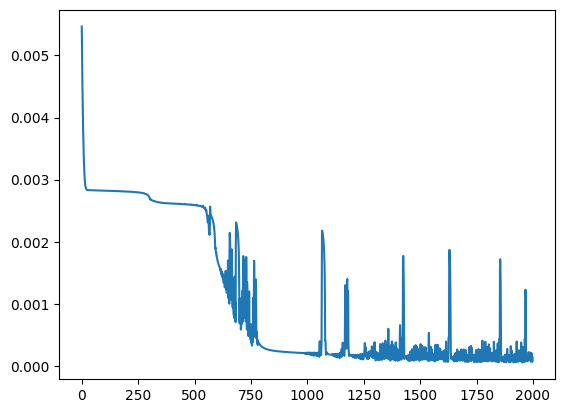

In [ ]:
print(f'Min Loss {min(loss_values):.8f}')
plt.plot(loss_values)
plt.show()

# Load Best Model

In [ ]:
best_model = StructuralResponseLSTM(input_size, hidden_lstm_size, out_features, num_layers)#.to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

StructuralResponseLSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (linear1): Linear(in_features=128, out_features=2, bias=True)
)

# Load Last Model

In [ ]:
last_model = StructuralResponseLSTM(input_size, hidden_lstm_size, out_features, num_layers)#.to(DEVICE)
last_model.load_state_dict(torch.load(last_model_path))
last_model.eval()

StructuralResponseLSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (linear1): Linear(in_features=128, out_features=2, bias=True)
)

# Inspecting Performance

In [ ]:
from scipy.stats import pearsonr
from math import sqrt
import scipy.fft as ft

def plot_for_index(selected_model,index,x_data,y_data,feature,range=None):
  seq_1 = y_data[index,:,feature].numpy()
  seq_2 = selected_model(x_data[index])[:,feature].detach().numpy()

  seq_1 = dataset.rebase_sequence(seq_1,feature)
  seq_2 = dataset.rebase_sequence(seq_2,feature)

  plot_data_range(seq_1,seq_2 ,"Displacement" if (feature > 0) else "Acceleration", "Time (sec)", "Displacement (m)" if (feature > 0) else "Acceleration (m/s^2)" , "Real" , "Predicted",range)

def plot_data_range(sequence1, sequence2, title, xlabel, ylabel, label1="Real", label2="Predicted", range=None):
  x = np.arange(start=0, stop=len(sequence1), step=1) * 0.005 # time step is 0.005

  plt.plot(x, sequence1, label=label1)
  plt.plot(x, sequence2, "--", label=label2)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if range != None:
    plt.xlim(range)
  plt.legend()
  plt.show()

def correlation_for_index(selected_model,index,x_data,y_data,feature):
  corr,_ = pearsonr(np.squeeze(selected_model(x_data[index])[:,feature].detach().numpy()), np.squeeze(y_data[index,:,feature].numpy()))
  return corr

def correlation_for_all(selected_model,x_data,y_data,feature):
  corr_coeffs = np.zeros(x_data.shape[0])
  for i in range(x_data.shape[0]):
    corr_coeffs[i] = correlation_for_index(selected_model,i,x_data,y_data,feature)
  return corr_coeffs

def print_correlation_for_all(selected_model,x_data,y_data,feature):
  corr_coeffs = correlation_for_all(selected_model,x_data,y_data,feature)
  for i in range(corr_coeffs.shape[0]):
    print(f'# {i:2.0f} | {corr_coeffs[i]:5.2f}')
  print(f'-----------------------------')
  print(f'max correlation  = {corr_coeffs.max():5.2f}')
  print(f'mean correlation = {np.mean(corr_coeffs):5.2f}')

def plot_cav_for_index(selected_model,index,x_data,y_data,feature):
  seq_1 = y_data[index,:,feature].numpy()
  seq_2 = selected_model(x_data[index])[:,feature].detach().numpy()

  seq_1 = dataset.rebase_sequence(seq_1,feature)
  seq_2 = dataset.rebase_sequence(seq_2,feature)

  seq_1_cav = np.cumsum(np.abs(seq_1))*0.005 # dt
  seq_2_cav = np.cumsum(np.abs(seq_2))*0.005 # dt

  plot_data(seq_1_cav,seq_2_cav ,"CAV", "Time (sec)", "CAV  (m/s)" , "Real" , "Predicted")

def apply_dft(signal_Y,dt,N_f=0,get_half_band=True,UseDecibel=False):
    N_t=len(signal_Y)
    if N_f<1:
        N_f=N_t
    if get_half_band:
        tr_limit= N_f//2
    else:
        tr_limit= N_f

    DFT_X = ft.fft(np.concatenate([signal_Y, np.zeros(N_f-N_t)])) #FFT zero-padded t length K
    phase_X  = np.angle(DFT_X); phase_X  = phase_X[0:tr_limit] / np.pi
    DFT_Amp_X=(2.0/N_t)*np.abs(DFT_X)[0:tr_limit]
    freq_values_X = ft.fftfreq(N_f, dt)[0:tr_limit]
    DFT_X = DFT_X[0:tr_limit]

    if UseDecibel:
        DFT_Amp_X=10*np.log10(DFT_Amp_X)

    return DFT_X,freq_values_X,DFT_Amp_X,phase_X


def plot_dft_for_index(selected_model,index,x_data,y_data,feature):
  seq_1 = y_data[index,:,feature].numpy()
  seq_2 = selected_model(x_data[index])[:,feature].detach().numpy()

  seq_1 = dataset.rebase_sequence(seq_1,feature)
  seq_2 = dataset.rebase_sequence(seq_2,feature)

  dt=0.005
  DFT_1,freq_values_1,DFT_Amp_1,phase_1=apply_dft(seq_1,dt,N_f=0,get_half_band=True)
  DFT_2,freq_values_2,DFT_Amp_2,phase_2=apply_dft(seq_2,dt,N_f=0,get_half_band=True)


  plot_dft_data(freq_values_1,DFT_Amp_1,DFT_Amp_2 ,"DFT", "Frequency (Hz)", "|acc(f)|" , "Real" , "Predicted")

def plot_dft_data(freq_values, sequence1, sequence2,title, xlabel, ylabel, label1="Real", label2="Predicted"):

  plt.plot(freq_values, sequence1, label=label1)
  plt.plot(freq_values, sequence2, "--", label=label2)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xlim((0,8))
  plt.legend()
  plt.show()


Correlation for training data (Acceleration)

In [ ]:
print_correlation_for_all(best_model,x_train,y_train,0) #Best Stored Model

#  0 |  0.98
#  1 |  0.96
#  2 |  0.99
#  3 |  0.99
#  4 |  0.98
#  5 |  0.99
#  6 |  0.99
#  7 |  0.97
#  8 |  0.96
#  9 |  0.97
# 10 |  0.93
# 11 |  0.99
# 12 |  0.97
# 13 |  0.98
# 14 |  0.99
# 15 |  0.99
# 16 |  0.98
# 17 |  0.88
# 18 |  0.97
# 19 |  0.99
# 20 |  0.99
# 21 |  0.97
# 22 |  0.99
# 23 |  0.99
# 24 |  0.99
# 25 |  0.98
# 26 |  0.93
# 27 |  0.92
# 28 |  0.98
# 29 |  0.99
# 30 |  0.99
# 31 |  0.97
-----------------------------
max correlation  =  0.99
mean correlation =  0.97


In [ ]:
print_correlation_for_all(last_model,x_train,y_train,0) #Last Model

#  0 |  0.95
#  1 |  0.94
#  2 |  0.95
#  3 |  0.97
#  4 |  0.96
#  5 |  0.96
#  6 |  0.97
#  7 |  0.94
#  8 |  0.93
#  9 |  0.95
# 10 |  0.92
# 11 |  0.97
# 12 |  0.95
# 13 |  0.95
# 14 |  0.98
# 15 |  0.97
# 16 |  0.95
# 17 |  0.86
# 18 |  0.95
# 19 |  0.96
# 20 |  0.95
# 21 |  0.95
# 22 |  0.95
# 23 |  0.97
# 24 |  0.97
# 25 |  0.95
# 26 |  0.91
# 27 |  0.91
# 28 |  0.95
# 29 |  0.96
# 30 |  0.97
# 31 |  0.94
-----------------------------
max correlation  =  0.98
mean correlation =  0.95


Correlation for training data (Displacement)

In [ ]:
print_correlation_for_all(best_model,x_train,y_train,1) #Best Stored Model

#  0 |  0.99
#  1 |  1.00
#  2 |  1.00
#  3 |  0.99
#  4 |  1.00
#  5 |  0.99
#  6 |  1.00
#  7 |  0.99
#  8 |  1.00
#  9 |  0.99
# 10 |  0.99
# 11 |  1.00
# 12 |  0.99
# 13 |  0.99
# 14 |  1.00
# 15 |  1.00
# 16 |  0.99
# 17 |  0.96
# 18 |  0.99
# 19 |  0.99
# 20 |  0.99
# 21 |  0.99
# 22 |  0.99
# 23 |  0.99
# 24 |  1.00
# 25 |  0.99
# 26 |  0.99
# 27 |  0.95
# 28 |  0.97
# 29 |  1.00
# 30 |  1.00
# 31 |  1.00
-----------------------------
max correlation  =  1.00
mean correlation =  0.99


In [ ]:
print_correlation_for_all(last_model,x_train,y_train,1) #Last Model

#  0 |  0.96
#  1 |  0.98
#  2 |  0.97
#  3 |  0.98
#  4 |  0.98
#  5 |  0.96
#  6 |  0.98
#  7 |  0.96
#  8 |  0.98
#  9 |  0.97
# 10 |  0.97
# 11 |  0.98
# 12 |  0.96
# 13 |  0.96
# 14 |  0.99
# 15 |  0.97
# 16 |  0.97
# 17 |  0.92
# 18 |  0.97
# 19 |  0.97
# 20 |  0.96
# 21 |  0.97
# 22 |  0.96
# 23 |  0.96
# 24 |  0.97
# 25 |  0.96
# 26 |  0.96
# 27 |  0.92
# 28 |  0.93
# 29 |  0.97
# 30 |  0.97
# 31 |  0.98
-----------------------------
max correlation  =  0.99
mean correlation =  0.96


Correlation for testing data (Acceleration)

In [ ]:
print_correlation_for_all(best_model,x_test,y_test,0)#Best Stored Model

#  0 |  0.97
#  1 |  0.89
#  2 |  0.98
#  3 |  0.97
#  4 |  0.96
#  5 |  0.98
#  6 |  0.98
#  7 |  0.98
-----------------------------
max correlation  =  0.98
mean correlation =  0.97


In [ ]:
print_correlation_for_all(last_model,x_test,y_test,0)#Last Model

#  0 |  0.94
#  1 |  0.88
#  2 |  0.96
#  3 |  0.95
#  4 |  0.93
#  5 |  0.96
#  6 |  0.96
#  7 |  0.96
-----------------------------
max correlation  =  0.96
mean correlation =  0.94


Correlation for testing data (Displacement)

In [ ]:
print_correlation_for_all(best_model,x_test,y_test,1)#Best Stored Model

#  0 |  0.98
#  1 |  0.91
#  2 |  0.99
#  3 |  1.00
#  4 |  0.96
#  5 |  0.99
#  6 |  0.99
#  7 |  0.99
-----------------------------
max correlation  =  1.00
mean correlation =  0.98


In [ ]:
print_correlation_for_all(last_model,x_test,y_test,1)#Last Model

#  0 |  0.95
#  1 |  0.87
#  2 |  0.97
#  3 |  0.98
#  4 |  0.92
#  5 |  0.96
#  6 |  0.96
#  7 |  0.96
-----------------------------
max correlation  =  0.98
mean correlation =  0.95


# Training Samples

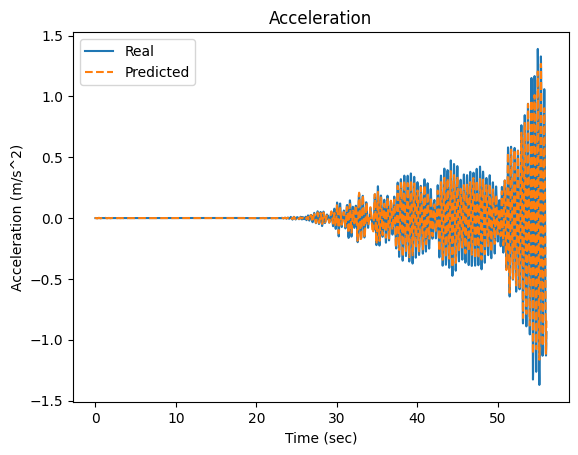

In [ ]:
plot_for_index(best_model,14,x_train,y_train,0)

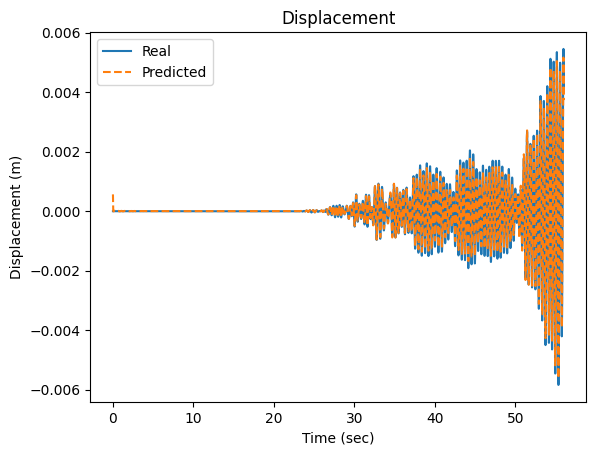

In [ ]:
plot_for_index(best_model,14,x_train,y_train,1)

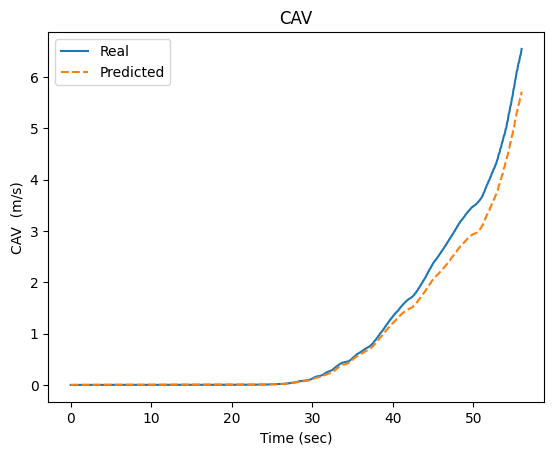

In [ ]:
plot_cav_for_index(best_model,14,x_train,y_train,0)

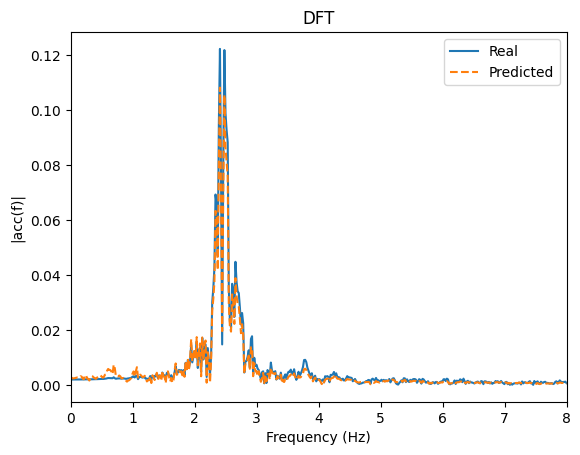

In [ ]:
plot_dft_for_index(best_model,14,x_train,y_train,0)

# Testing Samples

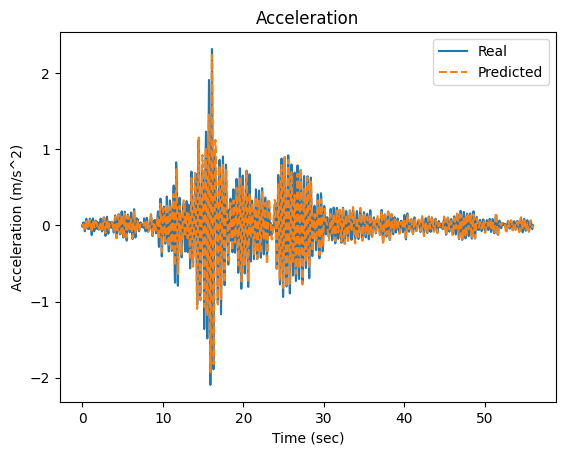

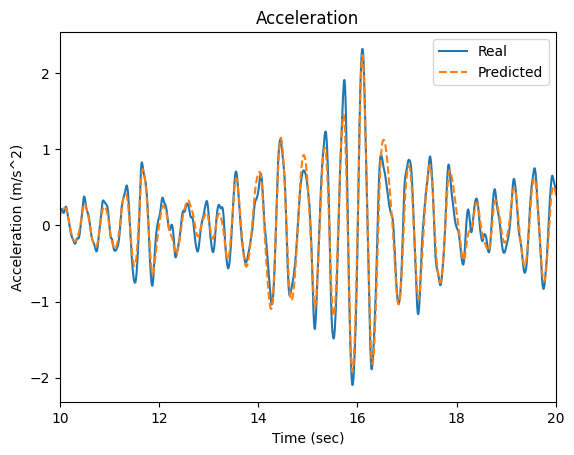

In [ ]:
plot_for_index(best_model,3,x_test,y_test,0)
plot_for_index(best_model,3,x_test,y_test,0,(10,20))

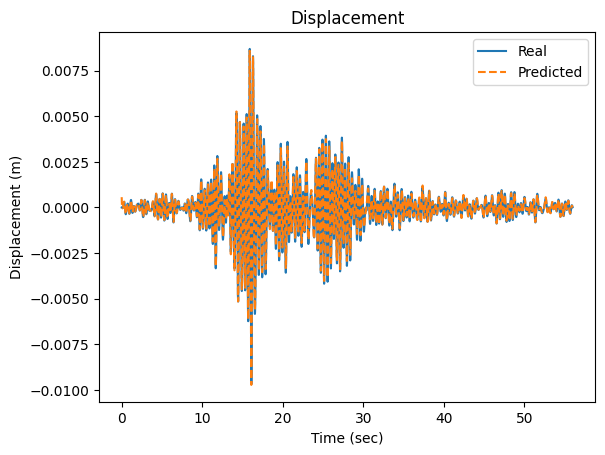

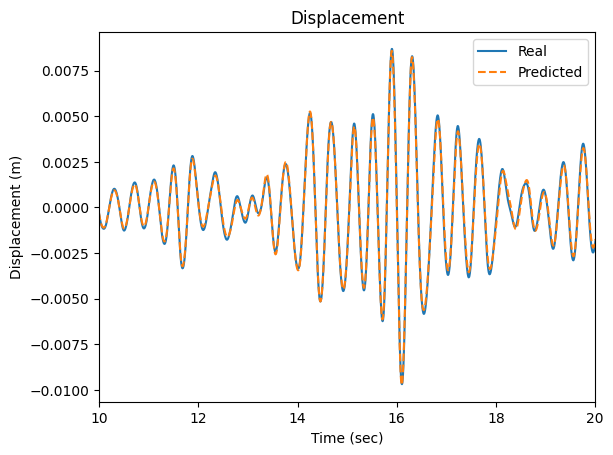

In [ ]:
plot_for_index(best_model,3,x_test,y_test,1)
plot_for_index(best_model,3,x_test,y_test,1,(10,20))

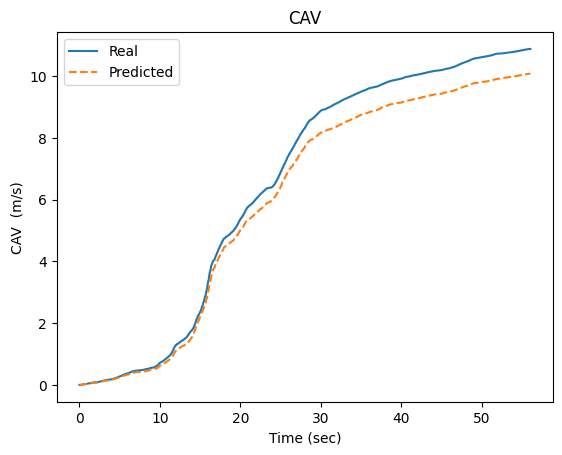

In [ ]:
plot_cav_for_index(best_model,3,x_test,y_test,0)

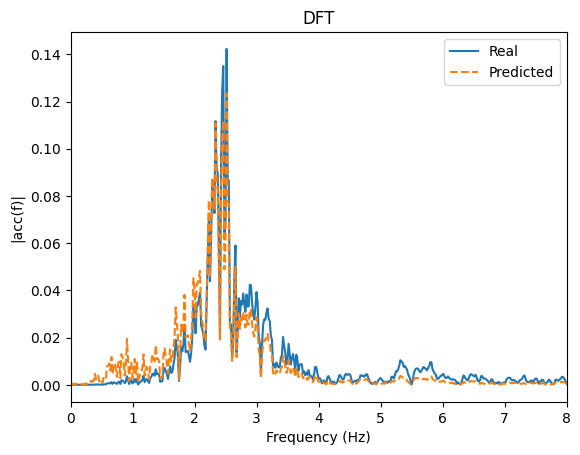

In [ ]:
plot_dft_for_index(best_model,3,x_test,y_test,0)

# End of testing